from sklearnex import patch_sklearn
patch_sklearn()

# IO

In [1]:
from PineBioML import IO

In [2]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [3]:
x, y = IO.read_multiple_groups(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

In [4]:
y

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
195    1.0
196    1.0
197    1.0
198    1.0
199    1.0
Length: 200, dtype: float64

In [5]:
target_label = 1.0

# Train test split

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=142, shuffle=True)

# Experiment

In [7]:
from PineBioML.model.utils import Pine, sklearn_esitimator_wrapper

In [8]:
from PineBioML.preprocessing import Normalizer, Pass
from PineBioML.preprocessing.impute import knn_imputer, simple_imputer
from PineBioML.preprocessing.utils import feature_extension
from PineBioML.selection.classification import essemble_selector
from PineBioML.model.supervised import Classification
from sklearn.linear_model import LogisticRegression


# define the experiment pipeline
experiment = [
    ("MissingValueProcessing", {
        "mean": simple_imputer(threshold=1., strategy="mean")
        }),
    ("Standarization", {
        #"PowerTransformer": Normalizer(method="PowerTransformer"), 
        "StandardScaler": Normalizer(method="StandardScaler"),
        }),
    ("Selection", {
        "ensemble":essemble_selector(RF_trees=256, z_importance_threshold = 1), 
        "None": Pass()
        }),
    ("Modeling", {
        "LgisticRegression": sklearn_esitimator_wrapper(LogisticRegression(penalty = None)),
        "RandomForest": Classification.RandomForest_tuner(target="mcc",validate_penalty=True),
        "XGBoost": Classification.XGBoost_tuner(validate_penalty=True),
        }),
]

In [9]:
pine_automl = Pine(experiment, target_label = target_label, cv_result= True)
result = pine_automl.do_experiment(x_train, y_train, x_valid, y_valid)


Using  c45  to select.


100%|██████████| 100/100 [00:00<00:00, 176.95it/s]


c45  is done.

Using  RF_gini  to select.
RF_gini  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
Lightgbm  is done.

optuna seed 9244  |  validation seed 2896  |  model seed 6308
    RandomForest start tuning. it will take a while.
    optuna is better, best trial:  2
optuna seed 12743  |  validation seed 4622  |  model seed 13742
    XGBoost start tuning. it will take a while.
    optuna is better, best trial:  56
optuna seed 9244  |  validation seed 2896  |  model seed 6308
    RandomForest start tuning. it will take a while.
    optuna is better, best trial:  44
optuna seed 12743  |  validation seed 4622  |  model seed 13742
    XGBoost start tuning. it will take a while.
    optuna is better, best tria

In [10]:
# print the results, sort according to test_auc
result.sort_values("test_auc")

,MissingValueProcessing,Standarization,Selection,Modeling,train_sensitivity,train_f1,train_specificity,train_auc,train_mcc,train_accuracy,...,cv_mcc,cv_accuracy,cv_support,test_sensitivity,test_f1,test_specificity,test_auc,test_mcc,test_accuracy,test_support
2,mean,StandardScaler,ensemble,XGBoost,0.820896,0.827068,0.835821,0.883159,0.656790,0.828358,...,0.409312,0.701709,26.8,0.848485,0.727273,0.515152,0.647842,0.385695,0.681818,66
4,mean,StandardScaler,None,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.045265,0.521652,26.8,0.575758,0.584615,0.606061,0.649219,0.181902,0.590909,66
1,mean,StandardScaler,ensemble,RandomForest,0.835821,0.848485,0.865672,0.950546,0.701805,0.850746,...,0.417043,0.701709,26.8,0.818182,0.701299,0.484848,0.658402,0.321412,0.651515,66
5,mean,StandardScaler,None,XGBoost,0.835821,0.788732,0.716418,0.896525,0.556218,0.776119,...,0.235856,0.604274,26.8,0.878788,0.743590,0.515152,0.667126,0.422890,0.696970,66
3,mean,StandardScaler,None,LgisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.153800,0.574359,26.8,0.636364,0.626866,0.606061,0.669421,0.242536,0.621212,66
0,mean,StandardScaler,ensemble,LgisticRegression,0.746269,0.751880,0.761194,0.786812,0.507519,0.753731,...,0.464329,0.723932,26.8,0.818182,0.710526,0.515152,0.695133,0.349780,0.666667,66


In [11]:
# save the result
result.to_csv("./output/example_Pine_result.csv")

# Pick a model and save it

In [12]:
# notice that the model is not fitted yet
model = pine_automl.recall_model(id = 0)

In [13]:
# fit the model
model.fit(x_train, y_train)
y_valid_prob = model.predict_proba(x_valid)

Using  c45  to select.


100%|██████████| 100/100 [00:01<00:00, 93.77it/s] 


c45  is done.

Using  RF_gini  to select.
RF_gini  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
Lightgbm  is done.



### summary


 
              precision    recall  f1-score   support

         0.0       0.74      0.52      0.61        33
         1.0       0.63      0.82      0.71        33

    accuracy                           0.67        66
   macro avg       0.68      0.67      0.66        66
weighted avg       0.68      0.67      0.66        66

sensitivity: 0.818
specificity: 0.515


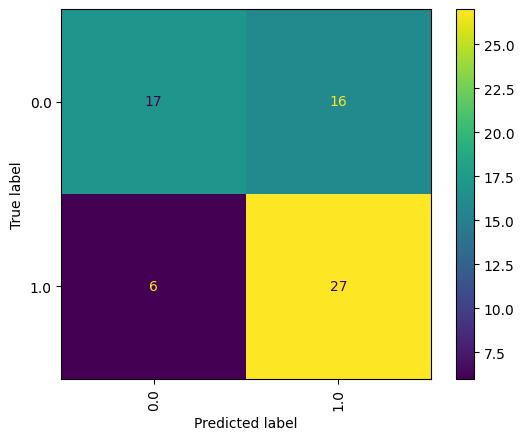

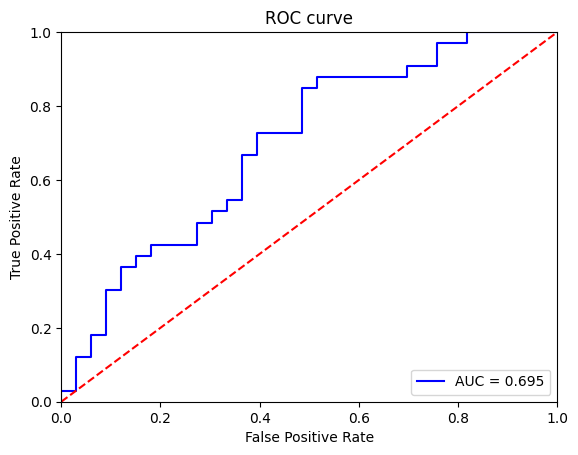

In [14]:
from PineBioML.report.utils import classification_summary

classification_summary(y_valid, y_valid_prob, target_label=target_label)

### save the model

In [15]:
IO.save_model(model, "./output/models/", "mode0", overide=True)

mode0  has already exist in  ./output/models/
It will be overide.
